## 1D Linear operator with two parameters

The previous examples focus on the systems with one parameter. To see if the framework can be applied to a more general case, we use 1D linear operator on two parameters, and verify the prediction. 

Here we set up the linear operator as following:

\begin{align*}
\mathcal{L}_x^\phi u(x) &= f(x) \\
\mathcal{L}_x^\phi &:= \phi_1 \cdot + \phi_2\frac{d}{dx}\cdot
\end{align*}


A suitable solution can be: 
\begin{align*}
u(x) &= sin(x) \\
f(x) &= \phi_1 sin(x) + \phi_2 cos(x) \\
x &\in [0, 1]
\end{align*}


In this example, we assume $\phi_1 = 2$ $ \phi_2 = 5$, and estimate $\phi_1$ $\phi_2$.


#### simulate data


In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
x = np.random.rand(20)
phi1 = 2.0
phi2 = 5.0
y_u = np.sin(x)
y_f = phi1*np.sin(x) + phi2*np.cos(x)

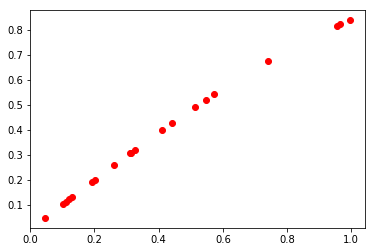

In [3]:

plt.plot(x, y_u, 'ro')
plt.show()

#### Evaluate kernels
Corresponding kernels are defined as following:

$
k_{uu}(x_i, x_j; \theta) = \theta exp(-\frac{1}{2l}(x_i-x_j)^2)
$

$
k_{ff}(x_i,x_j;\theta,\phi_1, \phi_2) \\
= \mathcal{L}_{x_i}^\phi \mathcal{L}_{x_j}^\phi k_{uu}(x_i, x_j; \theta) \\
= \mathcal{L}_{x_i}^\phi \left( \phi_1 k_{uu} + \phi_2 \frac{\partial}{\partial x_j}k_{uu} \right) \\
= \phi_1^2 k_{uu} + \phi_1 \phi_2 \frac{\partial}{\partial x_j}k_{uu} + \phi_1 \phi_2 \frac{\partial}{\partial x_i}k_{uu} + \phi_2^2 \frac{\partial}{\partial x_i}\frac{\partial}{\partial x_j}k_{uu}
$

$k_{fu}(x_i,x_j;\theta,\phi_1, \phi_2) \\
= \mathcal{L}_{x_i}^\phi k_{uu}(x_i, x_j; \theta) \\
= \phi_1 k_{uu} + \phi_2 \frac{\partial}{\partial x_i}k_{uu}$

$k_{uf}(x_i,x_j;\theta,\phi_1, \phi_2) \\
= \mathcal{L}_{x_j}^\phi k_{uu}(x_i, x_j; \theta) $ 

In [4]:
x_i, x_j, theta, phi1, phi2 = sp.symbols('x_i x_j theta phi1 phi2')
kuu_sym = sp.exp(theta*(-1)/(2)*((x_i - x_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, theta), kuu_sym, "numpy")
def kuu(x, theta):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], theta)
    return k

In [5]:
kff_sym = phi1**2*kuu_sym + phi1*phi2*sp.diff(kuu_sym, x_j) + phi1*phi2*sp.diff(kuu_sym, x_i) + phi2**2*sp.diff(kuu_sym, x_j, x_i)
kff_fn = sp.lambdify((x_i, x_j, theta, phi1,phi2), kff_sym, "numpy")
def kff(x, theta, phi1, phi2):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], theta, phi1, phi2)
    return k

In [6]:
kfu_sym = phi1*kuu_sym + phi2*sp.diff(kuu_sym, x_i)
kfu_fn = sp.lambdify((x_i, x_j, theta, phi1, phi2), kfu_sym, "numpy")
def kfu(x1, x2, theta, phi1, phi2):
    k = np.zeros((x1.size, x2.size))
    for i in range(x1.size):
        for j in range(x2.size):
            k[i,j] = kfu_fn(x1[i], x2[j], theta, phi1, phi2)
    return k

In [7]:
def kuf(x1, x2, theta, phi1, phi2):
    return kfu(x1,x2,theta,phi1, phi2).T

#### step 3: define negative log marginal likelihood  



$K = \begin{bmatrix}
k_{uu}(X_u, X_u; \theta) + \sigma_u^2I & k_{uf}(X_u, X_f; \theta, \phi) \\
k_{fu}(X_f, X_u; \theta, \phi) & k_{ff}(X_f, X_f; \theta, \phi) + \sigma_f^2I
\end{bmatrix}$

For simplicity, assume $\sigma_u = \sigma_f$.

$\mathcal{NLML} = \frac{1}{2} \left[ log|K| + y^TK^{-1}y + Nlog(2\pi) \right]$

where $y = \begin{bmatrix}
y_u \\
y_f
\end{bmatrix}$

In [8]:
def nlml(params, x1, x2, y1, y2, s):
    params = np.exp(params)
    K = np.block([
        [kuu(x1, params[0]) + s*np.identity(x1.size), kuf(x1, x2, params[0], params[1], params[2])],
        [kfu(x1, x2, params[0], params[1], params[2]), kff(x2, params[0], params[1], params[2]) + s*np.identity(x2.size)]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [9]:
nlml((1,2,5), x, x, y_u, y_f, 1e-7)


5931076.32677611

#### step 4: optimise hyperparameters


In [10]:
m = minimize(nlml, np.random.rand(3), args=(x, x, y_u, y_f, 1e-7), method="Nelder-Mead")
m

 final_simplex: (array([[-1.39714666,  0.69312524,  1.60943933],
       [-1.39716425,  0.69312265,  1.60943972],
       [-1.39716166,  0.69312471,  1.60943954],
       [-1.39705231,  0.69312267,  1.60943986]]), array([-277.79956725, -277.79956724, -277.79956723, -277.79956722]))
           fun: -277.7995672535838
       message: 'Optimization terminated successfully.'
          nfev: 314
           nit: 174
        status: 0
       success: True
             x: array([-1.39714666,  0.69312524,  1.60943933])

In [11]:

np.exp(m.x[1])


1.9999561258347431

In [12]:
np.exp(m.x[2])

5.000007099626661